# Apply Photometric Classification To Fit Results

This notebook applies the photometric classification method from González-Gaitán et al. 2014 to SDSS light-curve fit results.

In [1]:
import warnings
from pathlib import Path

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from astropy.table import Table
from bokeh.plotting import figure
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.utils import resample
from sndata.csp import dr1
from sndata.sdss import sako18

dr1.download_module_data()
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

# Output directory for figures
fig_dir = Path('./notebook_figs/classification')
fig_dir.mkdir(exist_ok=True, parents=True)


## Load Data

We read in the SDSS classificaions for supernovae and join these with our own photometric classification parameters. We create separate tables for the band-by-band and collective fit results.

In [2]:
# Read in sdss classifications
sdss_master = sako18.load_table('master')
sako_classification = pd.DataFrame({
    'obj_id': sdss_master['CID'],
    'spec_class': sdss_master['Classification']
})
sako_classification.set_index('obj_id', inplace=True)


In [3]:
def read_classification_data(path, sdss_class):
    """Read pipeline classification coordinates from file and join with sdss classifications
    
    Args:
        path             (str): Path of the file to read
        sdss_class (DataFrame): SDSS classifications
        
    Returns:
        A DataFrame of classification coords
    """

    # Read in our own classification data
    class_data = Table.read(path).to_pandas(index='obj_id')
    class_data['survey'] = 'SDSS'
    class_data['spec_class'] = 'Unspecified'

    # Update our table with sdss classifications
    class_data.update(sdss_class)
    return class_data


In [4]:
band_path = '../results/band_fits/with_ext/sdss_sako18_simple_fit_class.ecsv'
band_class = read_classification_data(band_path, sako_classification)

collective_path = '../results/collective_fits/with_ext/sdss_sako18_simple_fit_class.ecsv'
collective_class = read_classification_data(collective_path, sako_classification)
collective_class.head()


,x,y,survey,spec_class
obj_id,,,,
10028,-30.734722,-61.826105,SDSS,SNIa?
10036,0.266537,0.091667,SDSS,pSNIa
10037,-1.158080,-0.182717,SDSS,zSNIa
1008,-3.745179,-0.493055,SDSS,zSNIa
10096,-5.129167,0.857690,SDSS,SNIa


We also read in the actual fit results.

In [5]:
def read_fits_data(path):
    """Read pipeline fit results from file
    
    Args:
        path             (str): Path of the file to read
        
    Returns:
        A DataFrame of fit results
    """
        
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fits_data = Table.read(path).to_pandas()
        
    return fits_data.set_index(['source', 'obj_id'])


In [6]:
band_fits_path = '../results/band_fits/with_ext/sdss_sako18_simple_fit_fits.ecsv'
band_fits = read_fits_data(band_fits_path)
band_fits['band'] = [str(b)[-2] if b != 'all' else b for b in band_fits.band]

collective_fits_path = '../results/collective_fits/with_ext/sdss_sako18_simple_fit_fits.ecsv'
collective_fits = read_fits_data(collective_fits_path)
collective_fits.head()


message  band  pre_max  post_max  \
source   obj_id                                                               
hsiao_x1 10028   Minimization exited successfully.   all     85.0      20.0   
         10028   Minimization exited successfully.  blue     34.0       8.0   
         10028   Minimization exited successfully.   red     51.0      12.0   
sn91bg   10028   Minimization exited successfully.   all     90.0      15.0   
         10028   Minimization exited successfully.  blue     36.0       6.0   

                           vparams        x1         z     mwebv  \
source   obj_id                                                    
hsiao_x1 10028     t0,amplitude,x1 -0.141844  0.064256  0.021712   
         10028        amplitude,x1 -0.145933  0.064256  0.021712   
         10028        amplitude,x1 -0.097498  0.064256  0.021712   
sn91bg   10028   t0,amplitude,x1,c  1.250000  0.064256  0.021712   
         10028      amplitude,x1,c  1.250000  0.064256  0.021712   

                    amplitude            t0  ...    x1_err  z_err  mwebv_err  \
source   obj_id                              ...                               
hsiao_x1 10028   2.190522e-04  2.453694e+06  ...  0.006495    NaN        NaN   
         10028   2.120636e-04  2.453694e+06  ...  0.007042    NaN        NaN   
         10028   2.255190e-04  2.453694e+06  ...  0.009119    NaN        NaN   
sn91bg   10028   1.127964e-15  2.453696e+06  ...  0.000312    NaN        NaN   
         10028   1.810954e-15  2.453696e+06  ...  0.000987    NaN        NaN   

                 amplitude_err    t0_err     c_err    chisq  ndof  b_max  \
source   obj_id                                                            
hsiao_x1 10028    7.311878e-07  0.085930       NaN   412.58  32.0 -19.16   
         10028    8.541001e-07       NaN       NaN    37.05  12.0 -19.09   
         10028    7.930744e-07       NaN       NaN   155.38  19.0 -19.22   
sn91bg   10028    6.610183e-18  0.148604  0.000118  4755.33  26.0 -18.52   
         10028    1.320817e-17       NaN  0.005021   304.40   9.0 -19.04   

                 delta_15  
source   obj_id            
hsiao_x1 10028      1.330  
         10028      1.339  
         10028      1.233  
sn91bg   10028      1.446  
         10028      1.446  

[5 rows x 21 columns]

## Exploration of Failed Fits

We perform a cursory investigation of any fits that have failed to converge. To start, we note the unique error messages raised in the band and collective fit results.

In [7]:
def get_failed_fits(fits_df):
    """Select failed fits from a dataframe"""
    
    failed_fits = fits_df['message'].str.lower().str.contains('failed')
    return fits_df[failed_fits]
    

In [8]:
print('Band fit error messages:\n')
print(get_failed_fits(band_fits).message.unique())

print('\nCollective fit error messages:\n')
print(get_failed_fits(collective_fits).message.unique())


Band fit error messages:

['No data points with S/N > 5.0. Initial guessing failed.'
 'Hesse Failed. Covariance may not be accurate. Covariance not positive definite.']

Collective fit error messages:

['No data points with S/N > 5.0. Initial guessing failed.'
 'Hesse Failed. Covariance may not be accurate. Covariance not positive definite.']


The SNR error is not concerning so long as there are an equal number of occurences between the band and collective fits.

In [9]:
snr_err_msg = 'No data points with S/N > 5.0. Initial guessing failed.'
band_snr_indices = band_fits.message == snr_err_msg
collective_snr_indices = collective_fits.message == snr_err_msg
equal_errors = sum(band_snr_indices) == sum(collective_snr_indices)

print('Equal Number of SNR errors:', equal_errors)


Equal Number of SNR errors: True


We drop the SNR errors for now and look at the distribution of the remaining errors across bands and models.

In [10]:
goodsnr_band_fits = band_fits[band_fits.message != snr_err_msg]
goodsnr_collective_fits = collective_fits[collective_fits.message != snr_err_msg]


In [11]:
band_failed_nosnr = get_failed_fits(goodsnr_band_fits)

print('Band by band error distribution\n')
print('By fitted band (set):')
print(band_failed_nosnr.band.str[-2].value_counts())

print('\nNumber of failed fits per source:')
print(band_failed_nosnr.droplevel(1).index.value_counts())

print('\nNumber of failed fits per object (num_failures number_targets):')
print(band_failed_nosnr.index.value_counts().value_counts())


Band by band error distribution

By fitted band (set):
Series([], Name: band, dtype: int64)

Number of failed fits per source:
sn91bg      1
hsiao_x1    1
Name: source, dtype: int64

Number of failed fits per object (num_failures number_targets):
1    2
dtype: int64


In [12]:
collective_failed_nosnr = get_failed_fits(goodsnr_collective_fits)

print('Collective error distribution\n')
print('By fitted band (set):')
print(collective_failed_nosnr.band.value_counts())

print('\nNumber of failed fits per source:')
print(collective_failed_nosnr.droplevel(1).index.value_counts())

print('\nNumber of failed fits per object (num_failures number_targets):')
print(collective_failed_nosnr.index.value_counts().value_counts())


Collective error distribution

By fitted band (set):
blue    1
Name: band, dtype: int64

Number of failed fits per source:
sn91bg    1
Name: source, dtype: int64

Number of failed fits per object (num_failures number_targets):
1    1
dtype: int64


## Classification

We apply the classification to the fitted light curves.

In [13]:
def create_border_hist(axis, padding=0):
    """Create axes for plotting border histograms

    Args:
        axis     (Axis): The matplotlib axis to border
        padding (float): Spacing between the main and bordering axes

    Returns:
        Axis for the upper histogram
        Axis for the right side histogram
    """

    axis_pos = axis.get_position()
    axis_width = axis_pos.x1 - axis_pos.x0
    axis_height = axis_pos.y1 - axis_pos.y0

    histx_pos = axis.get_position()
    histx_pos.y0 += axis_height + padding
    histx_pos.y1 = histx_pos.y0 + .35 * axis_height + padding
    histx = plt.axes(histx_pos)
    histx.set_xlim(axis.get_xlim())
    histx.tick_params(direction='in', labelbottom=False)

    histy_pos = axis.get_position()
    histy_pos.x0 += axis_width + padding
    histy_pos.x1 = histy_pos.x0 + .35 * axis_width + padding
    histy = plt.axes(histy_pos)
    histy.set_ylim(axis.get_ylim())
    histy.tick_params(direction='in', labelleft=False)

    return histx, histy


def calc_delta_chisq(fits_df):
    """Calculate the difference in reduces chisq for overall fits

    Args:
        fits_df (DataFrame): Pipeline fit results

    Returns:
        A pandas series
    """

    fits_hsiao = fits_df.loc['hsiao_x1']
    fits_hsiao = fits_hsiao[fits_hsiao.band == 'all']
    fits_sn91bg = fits_df.loc['sn91bg']
    fits_sn91bg = fits_sn91bg[fits_sn91bg.band == 'all']
    return (fits_hsiao.chisq / fits_hsiao.ndof) - (
            fits_sn91bg.chisq / fits_sn91bg.ndof)


def get_sako_pec():
    """Get objects flagged as peculiad in Sako+ 2018"""
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sako_data = sako18.load_table('master').to_pandas(index='CID')

    flagged = sako_data.reindex(sako_data.Notes.dropna().index) 
    flagged = flagged[flagged.Notes > 1]
    return flagged


In [14]:
def plot_chisq_scatter(fits_df):
    """Plot classification results

    Args:
        fits_df (DataFrame): DataFrame of fit results
    """
    
    delta_chi = calc_delta_chisq(fits_df)
    chi_lt0 = delta_chi[delta_chi < 0].index
    chi_gt0 = delta_chi[delta_chi > 0].index

    all_fits =  fits_df[fits_df.band == 'all']
    chisq_hs = all_fits.loc['hsiao_x1'].chisq / all_fits.loc['hsiao_x1'].ndof
    chisq_bg = all_fits.loc['sn91bg'].chisq / all_fits.loc['sn91bg'].ndof
    chisq = pd.DataFrame(dict(chisq_hs=chisq_hs, chisq_bg=chisq_bg))

    fig, axis = plt.subplots(1, 1, figsize=(7 / 2, 7 / 2))
    labels = (r'$\Delta\chi^2 < 0$', r'$\Delta\chi^2 > 0$')
    for index, label in zip((chi_lt0, chi_gt0), labels):
        plot_data = chisq.reindex(index)
        axis.scatter(plot_data.chisq_hs, plot_data.chisq_bg, 
                     s=5, alpha=.2, label=label)

    ylim = axis.get_ylim()
    axis.plot(ylim, ylim, linestyle='--', color='grey')
    axis.set_xscale('log')
    axis.set_yscale('log')
    axis.set_xlabel(r'Reduced Hsiao $\chi^2$')
    axis.set_ylabel(r'Reduced SN91bg $\chi^2$')
    axis.legend(framealpha=1)
    return fig, axis


def plot_classification(class_df, fits_df, border_bins, padding):
    """Plot classification results

    Args:
        class_df  (DataFrame): Classification coordinates
        class_df  (DataFrame): Classification results from collective fitting
        fits_df   (DataFrame): DataFrame of fit results
        border_bins (ndarray): Bins for histogram
        padding       (float): Spacing between the main and bordering axes
    """

    fig, axis = plt.subplots(1, 1, figsize=(7 / 2, 7 / 2))
    x_label = r'$\chi^2_\text{blue}$ (Ia) - $\chi^2_\text{blue}$ (91bg)'
    y_label = r'$\chi^2_\text{red}$ (Ia) - $\chi^2_\text{red}$ (91bg)'
    markers = {2: 's', 3: '^', 4: 'o', 5: 'v'}
    labels = {2: '91bg', 3: '00cx', 4: '02ci', 5: '02cx'}

    delta_chi = calc_delta_chisq(fits_df)
    chi_lt0 = delta_chi[delta_chi < 0]
    chi_gt0 = delta_chi[delta_chi > 0]

    sako_pec = get_sako_pec()
    all_data_lt = class_df.reindex(chi_lt0.index).drop(sako_pec.index, errors='ignore')
    all_data_gt = class_df.reindex(chi_gt0.index).drop(sako_pec.index, errors='ignore')
    
    axis.scatter(all_data_lt.x, all_data_lt.y, s=10, alpha=.7)
    axis.scatter(all_data_gt.x, all_data_gt.y, s=10, color='C1', alpha=.7)
    
    axis.axvline(0, color='grey', linestyle='--')
    axis.axhline(0, color='grey', linestyle='--')
    axis.set_xlabel(x_label, fontsize=12, labelpad=10)
    axis.set_ylabel(y_label, fontsize=12)
    axis.set_xlim(-75, 75)
    axis.set_ylim(-50, 50)
    
    for flag_type, flag_data in sako_pec.groupby('Notes'):
        plt_data = class_df.reindex(flag_data.index)
        marker = markers[flag_type]
        label = labels[flag_type]
        axis.scatter(plt_data.x, plt_data.y, s=20, 
                     marker=marker, zorder=9,
                     color='k', label=label, facecolor='none')

    histx, histy = create_border_hist(axis, padding)
    histx.hist([all_data_lt.x, all_data_gt.x], bins=border_bins, stacked=True)
    histy.hist([all_data_lt.y, all_data_gt.y], bins=border_bins,
               stacked=True, orientation='horizontal')

    histx.set_xlim(axis.get_xlim())
    histy.set_ylim(axis.get_ylim())
    histx.set_yscale('log')
    histy.set_xscale('log')
    return fig, axis


/anaconda3/envs/phot_class/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
/anaconda3/envs/phot_class/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  This is separate from the ipykernel package so we can avoid doing imports until


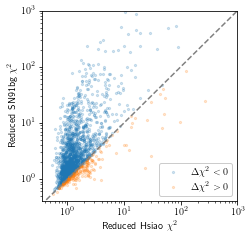

In [15]:
chisq_scat_fig, chisq_scat_axis = plot_chisq_scatter(collective_fits)
chisq_scat_axis.set_xlim(0, 1e3)
chisq_scat_axis.set_ylim(0, 1e3)

plt.savefig(fig_dir / 'chisq_scatter.pdf', bbox_inches='tight')
plt.show()


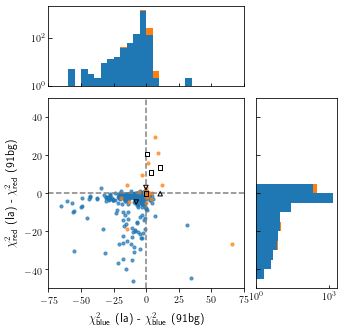

In [16]:
coll_fig, coll_axis = plot_classification(
    class_df=collective_class, 
    fits_df=collective_fits, 
    border_bins=np.arange(-100, 100, 5),
    padding=.05
)
    
plt.savefig(fig_dir / 'collective_classification.pdf', bbox_inches='tight')
plt.show()


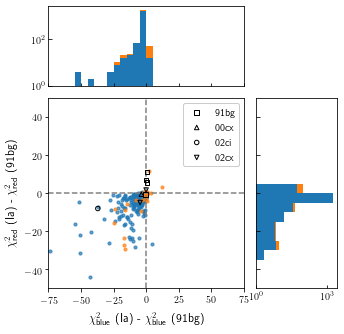

In [17]:
band_fig, band_axis = plot_classification(
    class_df=band_class, 
    fits_df=band_fits, 
    border_bins=np.arange(-100, 100, 5),
    padding=.05
)
    
band_axis.legend(framealpha=1)

plt.savefig(fig_dir / 'band_classification.pdf', bbox_inches='tight')
plt.show()


We note that some of the points in quadrent 3 hace a $\Delta \chi^2$ greater than 0. For future or external reference, we note the object Id for the point furthest away from the origin.

In [18]:
# Get object Ids with delta chisq > 0
delta_chi = calc_delta_chisq(collective_fits)
delta_gt0 = delta_chi[delta_chi > 0].index
delta_gt0_coords = collective_class.reindex(delta_gt0)

# Keep objects in quadrent 3
indices = (delta_gt0_coords.x < 0) & (delta_gt0_coords.y < 0)
delta_gt0_coords = delta_gt0_coords[indices]

# Sort by distance from origin
delta_gt0_coords['dist'] = ((delta_gt0_coords.x ** 2 + delta_gt0_coords.y ** 2) ** .5)
delta_gt0_coords.sort_values('dist', ascending=False).head()


,x,y,survey,spec_class,dist
obj_id,,,,,
13467,-15.023606,-18.635267,SDSS,SNIa?,23.937041
17263,-19.074868,-2.678873,SDSS,SNIa,19.262060
17500,-13.010151,-4.838953,SDSS,SNIa,13.880904
16202,-0.425397,-5.102308,SDSS,Unknown,5.120010
13996,-0.218699,-2.059177,SDSS,pSNIa,2.070758


In [19]:
import sncosmo
from phot_class import models
from phot_class import utils
from copy import deepcopy

models.register_sources(True)
sako18.register_filters(True)

def plot_fits(obj_id, collective_fits_df, band_fits_df):
    """Plot fit results for a given obj_id
    
    Args:
        obj_id                   (str): An SDSS object Id
        collective_fits_df (DataFrame): Collective fitting results
        band_fits_df       (DataFrame): Band fitting results
    """
    
    # Get light-curve data
    data = sako18.get_data_for_id(obj_id).to_pandas()
    blue_bands, red_bands = utils.split_bands(sako18.band_names, sako18.lambda_effective)
    blue_bands = blue_bands.tolist() + ['blue']
    red_bands = red_bands.tolist() + ['red']
    
    # Get model parameters
    collective_fits_df = collective_fits_df.set_index('band', append=True)
    band_fits_df = band_fits_df.set_index('band', append=True)
    hsiao_params = collective_fits_df.loc[('hsiao_x1', obj_id, 'all')]
    sn91bg_params = collective_fits_df.loc[('sn91bg', obj_id, 'all')]
    
    # Shift everything to MJD - 53000
    data.time -= 2453000.5
    collective_fits_df.t0 -= 2453000.5
    band_fits_df.t0 -= 2453000.5
    
    # Instantiate models with params for all bands
    hsiao_all = sncosmo.Model('hsiao_x1')
    hsiao_all.update({p: hsiao_params[p] for p in hsiao_all.param_names})
    
    sn91bg_all = sncosmo.Model(sncosmo.get_source('sn91bg', version='hsiao_phase'))
    sn91bg_all.update({p: sn91bg_params[p] for p in sn91bg_all.param_names})
    
    # Populate figure
    phase_arr = np.arange(data.time.min() - 10, data.time.max() + 10)
    fig, axes = plt.subplots(4, 2, figsize=(6, 12), sharey=True, sharex=True)
    for model, ax_column in zip((hsiao_all, sn91bg_all), axes.T):
        for (band_name, band_data), axis in zip (data.groupby('band'), ax_column):
            band_label = band_name[-2]
            
            # Create model for collective fits
            band_set = 'red' if band_name in red_bands else 'blue'
            coll_model = deepcopy(model)
            coll_params = collective_fits_df.loc[(model.source.name, obj_id, band_set)]
            coll_model.update({p: coll_params[p] for p in coll_model.param_names})
            
            # Create model for band fits
            band_model = deepcopy(model)
            band_params = band_fits_df.loc[(model.source.name, obj_id, band_label)]
            band_model.update({p: band_params[p] for p in band_model.param_names})

            axis.scatter(band_data.time, band_data.flux, color='k', s=5, label=band_label)
            axis.errorbar(band_data.time, band_data.flux, yerr=band_data.fluxerr, linestyle='', color='k')

            zp = data.zp[0]
            zpsys = data.zpsys[0]
            
            prefix = '_' if axis != ax_column[-1] else ''
            model_flux = model.bandflux(band_name, phase_arr, zp, zpsys)
            axis.plot(phase_arr, model_flux, linestyle='-', label=prefix + 'All bands')

            coll_model_flux = coll_model.bandflux(band_name, phase_arr, zp, zpsys)
            axis.plot(phase_arr, coll_model_flux, linestyle='--', color='k', label=prefix + band_set.title() + ' bands')
            
            band_model_flux = band_model.bandflux(band_name, phase_arr, zp, zpsys)
            axis.plot(phase_arr, band_model_flux, linestyle=':', color='C3', label=prefix + 'Band only')

    
    axes[0, 0].set_title('Hsiao', fontsize=16)
    axes[0, 1].set_title('SN91bg', fontsize=16)
    for axis in axes[:, 0]:
        axis.set_ylabel('Flux', fontsize=16, labelpad=10)
        
    for axis in axes[:, -1]:
        axis.legend(loc='upper left', fontsize=16, prop={'size': 12})
    
    for axis in axes[-1]:
        axis.set_xlabel('Time (MJD - 5300)', fontsize=16, labelpad=10)
    
    axis.set_ylim(0, 1.1 * max(data.flux))
    axis.set_xlim(phase_arr.min(), phase_arr.max())
    plt.tight_layout()
    

In [20]:
comparison_id = '15749'
plot_fits(comparison_id, collective_fits, band_fits)
plt.savefig(fig_dir / f'{comparison_id}_fit_comparison.pdf', bbox_inches='tight')


FileNotFoundError: [Errno 2] No such file or directory: '/anaconda3/envs/phot_class/lib/python3.7/site-packages/sndata/sdss/sako18/data/SDSS_dataRelease-snana/SDSS_allCandidates+BOSS/SDSS_allCandidates+BOSS.IGNORE'

## Intrinsic Properties

We consider the distribution of fit parameters.

In [ ]:
def plot_param_histogram(fits_df, source, fit_type, param):
    """Plot a histagram of fit parameters
    
    Args:
        fits_df (DataFrame): Fit results
        source        (str): Name of the model to display results for
        fit_type      (str): Use "band" or "collective" fit results
        param         (str): Name of the parameter to plot
    """
    
    # Select data to plot
    fits_with_source = fits_df.loc[source]
    band_data = fits_with_source.groupby('band')
    labels, data = np.transpose([[band, data[param]] for band, data in band_data])
    
    fig, axis = plt.subplots(1, 1, figsize=(7, 7))
    axis.hist(data, stacked=True, label=labels)
    
    latex_safe_source = source.split("_")[0]
    axis.set_title(param + f' Distribution ({latex_safe_source} - {fit_type} Fits)'.title())
    axis.set_xlabel(param)
    axis.set_ylabel('Combined number of targets')
    axis.legend()    


In [ ]:
for source in ('hsiao_x1', 'sn91bg'):
    for param in ('x1', 'c'):
        if source == 'hsiao_x1' and param == 'c':
            continue
            
        for fit_type, fit_data in zip(('band', 'collective'), (band_fits, collective_fits)):
            plot_param_histogram(fit_data, source, fit_type, param)
            plt.savefig(fig_dir / f'{param}_{source}_{fit_type}_fits.pdf'.lower())
            plt.show()


In [ ]:
def scatter_plot(x, y, c=None, contour=False, class_by=None, x_cutoff=0, y_cutoff=0):
    """Create a scatter plot with bordering histograms
    
    Args:
        x    (ndarray): x values to plot
        y    (ndarray): y values to plot
        c    (ndarray): Optional values for a colorbar
        contour (bool): Whether to plot contours
        class_by   (str): Classify by "collective" or "band" fits
        x_cutoff (float): The x cutoff for bg classifications
        y_cutoff (float): The y cutoff for bg classifications
        
    Returns:
        A seaborn figure
        A matplotlib axis for the color bar, if c is provided
    """
    
    joint_plot = sns.jointplot(x, y, height=8)
    scatter_ax = joint_plot.ax_joint
    
    if c is not None:
        scatter_ax.cla()
        basic_cols = ['blue', 'lightgrey', 'red']
        cmap = LinearSegmentedColormap.from_list('mycmap', basic_cols)
        s = scatter_ax.scatter(x, y, c=c, cmap=cmap, s=12)

        ax_pos = scatter_ax.get_position()
        ax_pos.y0 -= .2
        ax_pos.y1 = ax_pos.y0 + .05
        cbar_ax = plt.gcf().add_axes(ax_pos)
        plt.colorbar(s, cax=cbar_ax, orientation='horizontal')
        return joint_plot, cbar_ax 
    
    elif class_by is not None:
        x_coord = class_by.x
        y_coord = class_by.y
        sn91bg = class_by[(x_coord > x_cutoff) & (y_coord > y_cutoff)].index
        normal = class_by[(x_coord < x_cutoff) & (y_coord < y_cutoff)].index
        pec = class_by[(x_coord < x_cutoff) & (y_coord > y_cutoff)].index

        scatter_ax.cla()
        scatter_ax.scatter(x.reindex(normal), y.reindex(normal), 
                          color='C0',
                          s=12, label='Q3')
        
        scatter_ax.scatter(x.reindex(sn91bg), y.reindex(sn91bg), color='C3', marker='^', label='Q1')
        scatter_ax.scatter(x.reindex(pec), y.reindex(pec), color='C1', marker='s', label='Q2') 
        scatter_ax.legend()
        
    if contour:
        sns.kdeplot(x, y, ax=scatter_ax, color='black', alpha=.8)
        
    return joint_plot



In [ ]:
x_cut = .5
y_cut = 1
all_fits = collective_fits[collective_fits.band == 'all']

_ = scatter_plot(
    x=all_fits.loc['sn91bg'].x1, 
    y=all_fits.loc['sn91bg'].c, 
    class_by=collective_class,
    x_cutoff=x_cut, 
    y_cutoff=y_cut
)


## Host Galaxy Properties

We start with some book keeping and create dataframes for various subsets of the host galaxy data.

In [ ]:
host_photometry = pd.DataFrame({
    'obj_id': sdss_master['CID'],
    'host_id': sdss_master['objIDHost'],  # Host galaxy object ID in SDSS DR8 Database 
    'ra': sdss_master['RAhost'],  # Right ascension of galaxy host (degrees) 
    'dec': sdss_master['DEChost'],  # Declination of galaxy host (degrees) 
    'dist': sdss_master['separationhost'], # Distance from SN to host (arcsec) 
    'distnorm': sdss_master['DLRhost'], # Normalized distance from SN to host (dDLR) 
    'z_KF': sdss_master['zphothost'], # Host photometric redshift (KF algorithm) 
    'z_KF_err': sdss_master['zphoterrhost'], # zphothost uncertainty
    'z_RF': sdss_master['zphotRFhost'],  # Host photometric redshift (RF algorithm) 
    'z_RF_err': sdss_master['zphotRFerrhost'],  # zphotRFhost uncertainty 
    'u_mag': sdss_master['dereduhost'],  # Host galaxy u-band magnitude (dereddened) 
    'u_mag_err': sdss_master['erruhost'], # Host galaxy u-band magnitude uncertainty 
    'g_mag': sdss_master['deredghost'],  # Host galaxy g-band magnitude (dereddened)
    'g_mag_err': sdss_master['errghost'],  #  Host galaxy g-band magnitude uncertainty 
    'r_mag': sdss_master['deredrhost'],  # Host galaxy r-band magnitude (dereddened)
    'r_mag_err': sdss_master['errrhost'],  #  Host galaxy r-band magnitude uncertainty 
    'i_mag': sdss_master['deredihost'], # Host galaxy i-band magnitude (dereddened) 
    'i_mag_err': sdss_master['errihost'], # Host galaxy i-band magnitude uncertainty 
    'z_mag': sdss_master['deredzhost'], # Host galaxy z-band magnitude (dereddened) 
    'z_mag_err': sdss_master['errzhost'] # Host galaxy z-band magnitude (dereddened)
})
host_photometry.set_index('obj_id', inplace=True)
    
# Galaxy Parameters Calculated with FSPS
fsps_params = pd.DataFrame({
    'obj_id' : sdss_master['CID'],
    'logmass' : sdss_master['logMassFSPS'],  # FSPS log(M), M=Galaxy Mass (M in units of Me)
    'logmass_lo' : sdss_master['logMassloFSPS'],  # FSPS Lower limit of uncertainty in log(M)
    'logmass_hi' : sdss_master['logMasshiFSPS'],  # FSPS Upper limit of uncertainty in log(M)
    'logssfr' : sdss_master['logSSFRFSPS'],  # FSPS log(sSFR) sSFR=Galaxy Specific Star-forming Rate (SFR in Me yr−1)
    'logssfr_lo' : sdss_master['logSSFRloFSPS'],  # FSPS Lower limit of uncertainty in log(sSFR)
    'logssfr_hi' : sdss_master['logSSFRhiFSPS'],  # FSPS Upper limit of uncertainty in log(sSFR)
    'age' : sdss_master['ageFSPS'],  # FSPS galaxy age (Gyr)
    'age_lo' : sdss_master['ageloFSPS'],  # FSPS Lower limit of uncertainty in age
    'age_hi' : sdss_master['agehiFSPS'],  # FSPS Upper limit of uncertainty in age 
    'rchisq' : sdss_master['minredchi2FSPS'] # Reduced chi-squared of best FSPS template fit
})
fsps_params.set_index('obj_id', inplace=True)

# Galaxy Parameters Calculated with PÉGASE.2
pegase_params = pd.DataFrame({
    'obj_id' : sdss_master['CID'],
    'logmass' : sdss_master['logMassPEGASE'], # PÉGASE.2 log(M), M=Galaxy Mass (M in units of Me) 
    'logmass_lo' : sdss_master['logMassloPEGASE'], # PÉGASE.2 Lower limit of uncertainty in log(M)
    'logmass_hi' : sdss_master['logMasshiPEGASE'], # PÉGASE.2 Upper limit of uncertainty in log(SFR) 
    'logssfr' : sdss_master['logSFRPEGASE'], # PÉGASE.2 log(SFR) SFR=Galaxy star-forming rate (Me yr−1)
    'logssfr_lo' : sdss_master['logSFRloPEGASE'], # PÉGASE.2 Lower limit of uncertainty in log(SFR)
    'logssfr_hi' : sdss_master['logSFRhiPEGASE'], # PÉGASE.2 Upper limit of uncertainty in log(SFR)
    'age' : sdss_master['agePEGASE'], # PÉGASE.2 galaxy age (Gyr)
    'rchisq' : sdss_master['minchi2PEGASE']# Reduced chi-squared of best PÉGASE.2 fit
})
pegase_params.set_index('obj_id', inplace=True)


Next we define a few plotting functions to help simplify our work later on.

In [ ]:
def plot_host_property_distribution(col_name, bg_ids, normal_ids, *data_frames, **kwargs):
    """Plot histograms of host galaxy properties
    
    Args:
    col_name           (str): The name of the value to plot
    bg_ids          (Series): Object Ids of 91bg like SN
    normal_ids      (Series): Object Ids of normal SN
    *data_frames (DataFrame): Data frames with host galaxy data

    Returns:
        A matplotlib figure
        An array of matplotlib axes
    """
    
    fig, axes = plt.subplots(1, len(data_frames), sharex=True, sharey=True)
    if len(data_frames) == 1:
        axes = np.array([axes])
    
    for df, axis in zip(data_frames, axes.flatten()):
        
        plot_data = df[col_name]
        bg_data = plot_data.reindex(bg_ids).dropna()
        normal_data = plot_data.reindex(normal_ids).dropna()
        
        aks = stats.anderson_ksamp([normal_data, bg_data])
        sig_level = aks.significance_level
        
        _, bins, _ = axis.hist(
            normal_data,
            density=True,
            label=f'Normal ({len(normal_data)})', 
            **kwargs
        )
        
        axis.hist(bg_data, 
                  fill=False, 
                  hatch='///', 
                  density=True, 
                  histtype='step', 
                  label=f'91bg ({len(bg_data)})',
                  bins=bins
                 )
        
        title = r'(p $\geq$ 0.25)' if sig_level == 0.25 else f'(p = {sig_level:.2})'
        axis.set_title(title)

    axes[-1].legend()
    plt.tight_layout()
    return fig, axes
        

In [ ]:
bg_like = collective_class[(collective_class.x > x_cut) & (collective_class.y > y_cut)].index
normal = collective_class[(collective_class.x < x_cut) & (collective_class.y < y_cut)].index
print(len(bg_like))


In [ ]:
fig, axes = plot_host_property_distribution('logmass', bg_like, normal, fsps_params, pegase_params) 

axes[0].set_ylabel('Number of Targets', fontsize=16)
axes[0].set_title('FSPS ' + axes[0].get_title())
axes[1].set_title('PEGASE ' + axes[1].get_title())
for axis in axes:
    axis.set_xlabel(r'$\log(\text{M}_\odot)$', fontsize=16)
    
plt.savefig(fig_dir / 'collective_fits_mass.pdf', bbox_inches='tight')
plt.show()


In [ ]:
ssfr_data = pegase_params[pegase_params.logssfr > 0]
fig, axes = plot_host_property_distribution('logssfr', bg_like, normal, ssfr_data) 

axes[0].set_xlabel('SSFR', fontsize=16)
axes[0].set_ylabel('Number of Targets', fontsize=16)

plt.savefig(fig_dir / 'collective_fits_ssfr.pdf', bbox_inches='tight')
plt.show()


In [ ]:
ssfr_data = pegase_params[pegase_params.logssfr > 0]
fig, axes = plot_host_property_distribution('dist', bg_like, normal, host_photometry) 

axes[0].set_xlabel('Distance to Host Center', fontsize=16)
axes[0].set_ylabel('Number of Targets', fontsize=16)

plt.savefig(fig_dir / 'collective_fits_distance.pdf', bbox_inches='tight')
plt.show()


In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_pvalue(class_df, data, max_x=3.5, max_y=3.5, x_cutoff=0, y_cutoff=0, size=30):
    """Plot the p-value for host galaxy data as a function of cutoff value
    
    Args:
        class_df (DataFrame): Classification coordinates
        data        (Series): Host galaxy
        max_x        (float): Maximum for x-axis range
        max_y        (float): Maximum for y-axis range
        x_cutoff     (float): x classification boundary
        y_cutoff     (float): y classification boundary
        size         (float): Number of values to sample in x and y direction
        
    Returns:
        A matplotlib figure
        An array of matplotlib axes
    """
    
    sig_arr = np.zeros((size, size))
    count_arr = np.zeros((size, size))
    x_arr = np.linspace(0, max_x, sig_arr.shape[0])
    y_arr = np.linspace(0, max_y, sig_arr.shape[1])
    
    dx = (x_arr[1] - x_arr[0]) / 2
    dy = (y_arr[1] - y_arr[0]) / 2
    extent = [x_arr[0] - dx, x_arr[-1] + dx, y_arr[0] - dy, y_arr[-1] + dy]

    for i, xcut in enumerate(x_arr):
        for j, ycut in enumerate(y_arr):
            test_bg = class_df[(class_df.x > xcut) & (class_df.y > ycut)].index
            test_normal = class_df[(class_df.x < xcut) & (class_df.y < ycut)].index
            test_bg_data = data.reindex(test_bg).dropna()
            test_normal_data = data.reindex(test_normal).dropna()
            sig = stats.anderson_ksamp([test_normal_data, test_bg_data]).significance_level
            sig_arr[i, j] = sig
            count_arr[i, j] = len(test_bg_data)
    
    fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(7 / 2, 7))
    for axis, plot_data in zip(axes, (count_arr, sig_arr)):
        divider = make_axes_locatable(axis)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        im = axis.imshow(plot_data, extent=extent, origin='lower')
        fig.colorbar(im, cax=cax, orientation='vertical')
        axis.axvline(x_cutoff, linestyle='--', alpha=.8, color='red')
        axis.axhline(y_cutoff, linestyle='--', alpha=.8, color='red')

    axes[0].set_ylabel('y Cutoff', fontsize=10)
    axes[0].set_title('Number of 91bg points', fontsize=10)
    # axes[0].contour(x_arr, y_arr, count_arr, levels=np.arange(0, 50, 10), colors='red')
    
    axes[1].set_xlabel('x Cutoff', fontsize=10)
    axes[1].set_ylabel('y Cutoff', fontsize=10)
    axes[1].set_title(r'\textit{p}-Value')
    # axes[1].contour(x_arr, y_arr, sig_arr, levels=[0.05], colors='red')
    
    return fig, axes


In [ ]:
plot_pvalue(collective_class, fsps_params.logmass, x_cutoff=x_cut, y_cutoff=y_cut) 
plt.tight_layout()
plt.savefig(fig_dir / 'fsps_mass_pvalue.pdf', bbox_inches='tight')
plt.show()

plot_pvalue(collective_class, pegase_params.logmass, x_cutoff=x_cut, y_cutoff=y_cut) 
plt.savefig(fig_dir / 'pegase_mass_pvalue.pdf', bbox_inches='tight')
plt.show()

plot_pvalue(collective_class, ssfr_data.logssfr, x_cutoff=x_cut, y_cutoff=y_cut) 
plt.savefig(fig_dir / 'ssfr_pvalue.pdf', bbox_inches='tight')
plt.show()

plot_pvalue(collective_class, host_photometry.dist, x_cutoff=x_cut, y_cutoff=y_cut) 
plt.savefig(fig_dir / 'dist_pvalue.pdf', bbox_inches='tight')
plt.show()
